# Лабораторная работа №8. Рекуррентные нейронные сети для анализа временных рядов

**Данные:**

Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017. Данные в виде csv-файла можно скачать на сайте Kaggle -> https://www.kaggle.com/robervalt/sunspots/

In [0]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import re
import pdb
import pathlib
import re
import zipfile
import tensorflow_datasets as tfds
from statsmodels.tsa.seasonal import seasonal_decompose 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     print(
#         '\n\nThis error most likely means that this notebook is not '
#         'configured to use a GPU.  Change this in Notebook Settings via the '
#         'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#     raise SystemError('GPU device not found')

In [0]:
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/8/'

#### Tensorflow model wrapper

In [0]:
import random
import datetime

class Model:
    EPOCH_COUNT = 10
    
    def __init__(self, layers=[], model=None, optimizer=None, loss='sparse_categorical_crossentropy'):
        self.layers = layers
        self.model = model
        self.loss = loss
        self.optimizer = optimizer or tf.keras.optimizers.SGD(learning_rate=0.1)
        if not self.model:
            self.initialize()
        print('----------------------------------------------------------------------------------------')
        print(self.summary())
        print('----------------------------------------------------------------------------------------')

    def initialize(self):
        self.model = tf.keras.models.Sequential(self.layers)
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        
    def _train_on_batches(self, iterator, batch_count, epochs=None, **kwargs):
        epochs = epochs or self.EPOCH_COUNT
        loss, tran_accuracy, val_loss, val_accuracy = np.zeros((4, batch_count, epochs))

        for i in range(batch_count):
            print('----------------------------------------------------------------------------------------')
            print(f'Train on batch #{i}')
            print('----------------------------------------------------------------------------------------')
            x, y = next(iterator)
            batch_history = self.model.fit(x,  y, epochs=epochs, **kwargs)
            loss[i, :] = batch_history.history['loss']
            tran_accuracy[i, :] = batch_history.history['accuracy']
            if batch_history.history.get('val_accuracy'):
                val_accuracy[i, :] = batch_history.history.get('val_accuracy')[-1]
            if batch_history.history.get('val_loss'):
                val_loss[i, :] = batch_history.history.get('val_loss')[-1]

        val_loss = val_loss if np.any(val_loss) else None
        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_loss, val_accuracy

    def _train_on_full_data(self, iterator, epochs=None, **kwargs):
        print('----------------------------------------------------------------------------------------')
        print(f'Train on full data')
        print('----------------------------------------------------------------------------------------')
        epochs = epochs or self.EPOCH_COUNT
        history = self.model.fit(iterator, epochs=epochs, **kwargs)
        loss = np.array([history.history['loss']])
        tran_accuracy = np.array([history.history['accuracy']])
        val_loss = np.array([history.history.get('val_loss')])
        val_accuracy = np.array([history.history.get('val_accuracy')])

        val_loss = val_loss if np.any(val_loss) else None
        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_loss, val_accuracy

    def _plot_train_accuracy_graphs(self, loss, tran_accuracy, validation_loss=[], validation_accuracy=[], mode='batch'):
        print('----------------------------------------------------------------------------------------')
        if mode == 'batch':
            plt.figure(figsize=(15, 12))
            ax_shape = (2, 2)
        else:
            plt.figure(figsize=(15,5))
            ax_shape = (1, 2)

        xlabel = 'Epochs'
        ax = plt.subplot(*ax_shape, 1)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)

        epochs_loss = np.average(loss, axis=0)
        ax.plot(epochs_loss)
        if np.any(validation_loss):
            val_epochs_loss = np.average(validation_loss, axis=0)
            ax.plot(val_epochs_loss, '--')


        ax = plt.subplot(*ax_shape, 2)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)

        epochs_accuracy = np.average(tran_accuracy, axis=0)
        ax.plot(epochs_accuracy)
        if np.any(validation_accuracy):
            val_epochs_accuracy = np.average(validation_accuracy, axis=0)
            ax.plot(val_epochs_accuracy, '--')

        if mode == 'batch':
            xlabel = 'Batches'
            ax = plt.subplot(*ax_shape, 3)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Loss', fontsize=14)

            batches_loss = np.average(loss, axis=1)
            ax.plot(batches_loss)
            if np.any(validation_loss):
                val_batches_loss = np.average(validation_loss, axis=1)
                ax.plot(val_batches_loss, '--')

            ax = plt.subplot(*ax_shape, 4)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Accuracy', fontsize=14)

            batches_accuracy = np.average(tran_accuracy, axis=1)
            ax.plot(batches_accuracy)
            if np.any(validation_accuracy):
                val_batches_accuracy = np.average(validation_accuracy, axis=1)
                ax.plot(val_batches_accuracy, '--')
        
        plt.show()

    def _show_train_result(self, spent_time, average_loss, average_tran_accuracy, val_loss=None, val_accuracy=None):
        print('----------------------------------------------------------------------------------------')
        print('Spent time:', spent_time)
        print('Average loss error:', average_loss)
        print('Average train error:', average_tran_accuracy)
        if val_loss is not None:
            print('Average validation loss error:', val_loss)
        if val_accuracy is not None:
            print('Average validation error:', val_accuracy)
        print('----------------------------------------------------------------------------------------')

    def train(self, iterator, batch_count=None, show_accuracy_graph=True, **kwargs):
        now = datetime.datetime.now()
        val_accuracy = []

        if batch_count:
            loss, tran_accuracy, val_loss, val_accuracy =  self._train_on_batches(iterator, batch_count, **kwargs)
        else:
            print('----------------------------------------------------------------------------------------')
            print(f'Started at {now}')
            loss, tran_accuracy, val_loss, val_accuracy =  self._train_on_full_data(iterator, **kwargs)

        if show_accuracy_graph:
            mode = 'batch' if batch_count else 'epoch'
            self._plot_train_accuracy_graphs(loss, tran_accuracy, val_loss, val_accuracy, mode=mode)

        average_loss = np.average(loss)
        average_tran_accuracy = np.average(tran_accuracy)
        average_val_loss = np.any(val_loss) and np.average(val_loss)
        average_val_accuracy = np.any(val_accuracy) and np.average(val_accuracy)
        self._show_train_result(
            datetime.datetime.now() - now,
            average_loss,
            average_tran_accuracy,
            average_val_loss,
            average_val_accuracy
        )

        return {'loss': loss, 'accuracy': tran_accuracy, 'val_accuracy': val_accuracy}

    def test(self, x_test, y_test=None, **kwargs):
        return self.model.evaluate(x_test,  y_test, **kwargs)
    
    def summary(self):
        return self.model.summary()

    def predict(self, data, **kwargs):
        return self.model.predict(data, **kwargs)

    def save(self, **kwargs):
        filedir = kwargs.pop('filedir', './')
        filepath = filedir + kwargs.pop('filename', self.model.name)
        tf.keras.models.save_model(self.model, filepath, **kwargs)
    
    def parse_history(self, history):
        loss = np.array([history.history['loss']])
        tran_accuracy = np.array([history.history['accuracy']])
        val_loss = np.array([history.history.get('val_loss')])
        val_accuracy = np.array([history.history.get('val_accuracy')])
        self._plot_train_accuracy_graphs(loss, tran_accuracy, val_loss, val_accuracy, mode='epochs')

### Задание 1. Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

Скачиваем данные

In [0]:
dataset_path = f'{DRIVE_DIR}Sunspots.csv'
df = pd.read_csv(dataset_path)
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [0]:
df.head()

,index,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,,
1749-01-31,0,0,96.7
1749-02-28,1,1,104.3
1749-03-31,2,2,116.7
1749-04-30,3,3,92.8
1749-05-31,4,4,141.7


Выведем наш ряд

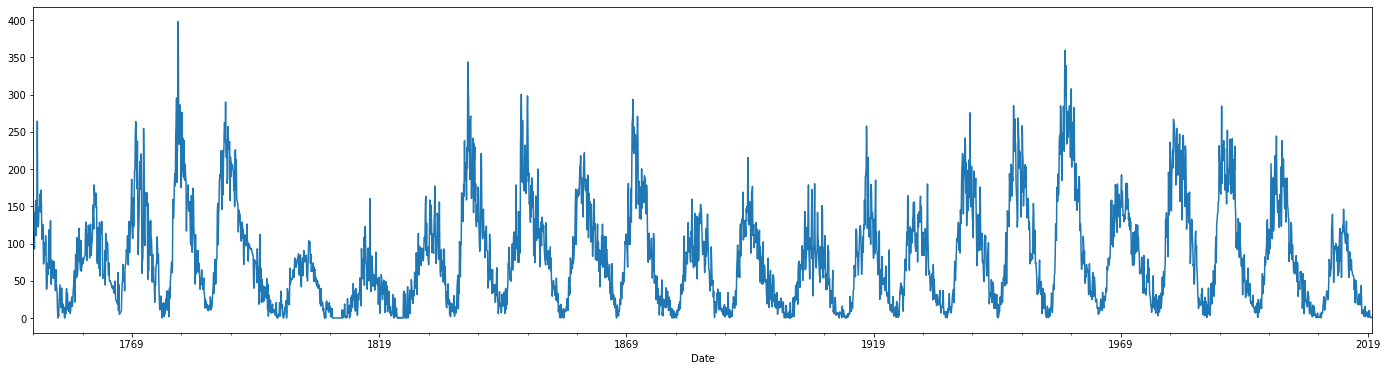

In [0]:
uni_data = df['Monthly Mean Total Sunspot Number']
uni_data.plot(figsize=(24,6))
plt.show()

Вид ряда говорит о том, что он нестационарный.

Предполагая, что наш ряд имеет аддитивную модель, вычислим тренд и сезонность. Для этого воспользуемся методом STL (A Seasonal-Trend Decomposition Procedure Based on Loess) - это процедура декомпозиции временного ряда на сезонную, трендовую составляющие и на остатки, использующую метод локальных регрессий (LOESS)

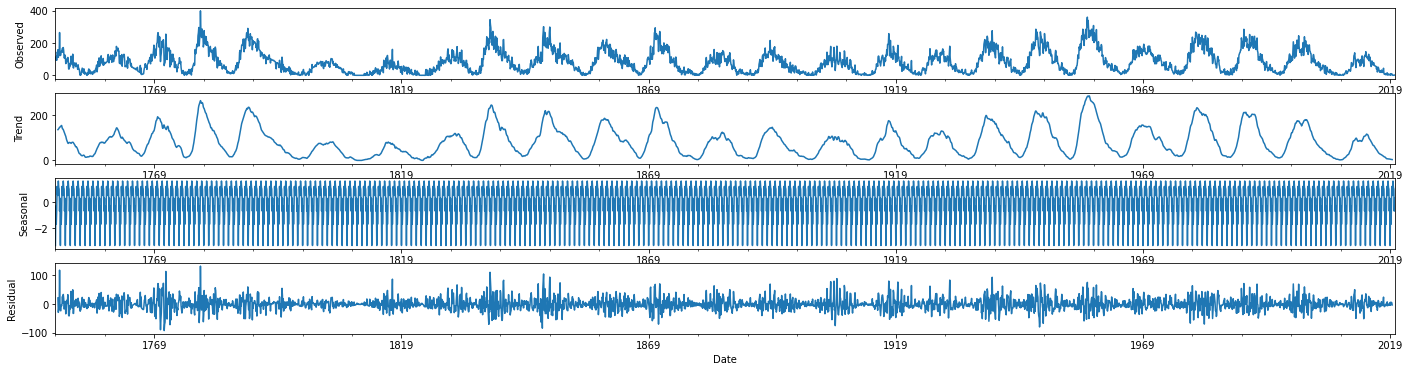

In [0]:
seasonal_decomposition = seasonal_decompose(df['Monthly Mean Total Sunspot Number'], model='additive')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(24,6))
ax1.set_ylabel('Observed')
ax2.set_ylabel('Trend')
ax3.set_ylabel('Seasonal')
ax4.set_ylabel('Residual')

seasonal_decomposition.observed.plot(ax=ax1)
seasonal_decomposition.trend.plot(ax=ax2)
seasonal_decomposition.seasonal.plot(ax=ax3)
seasonal_decomposition.resid.plot(ax=ax4)

Из графика тренда легко заметить, что тенденции на возрастании или на убывание ряд не имеет, следовательно, ряд не имеет ярковыраженного тренда. Из графика сезонности, видно, что ряд имеет сезон. Также график остатков показывает наличие выбросов. 

In [0]:
from pandas.plotting import autocorrelation_plot

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:409: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


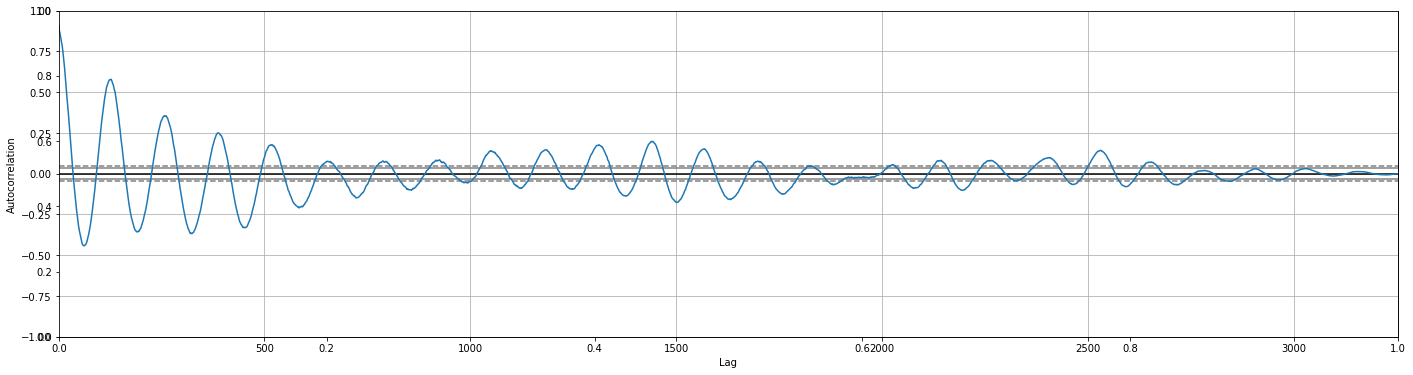

In [0]:
plt.subplots(1,1, figsize=(24,6))

autocorrelation_plot(df['Monthly Mean Total Sunspot Number'].values.tolist())

In [0]:
import statsmodels.api as sm

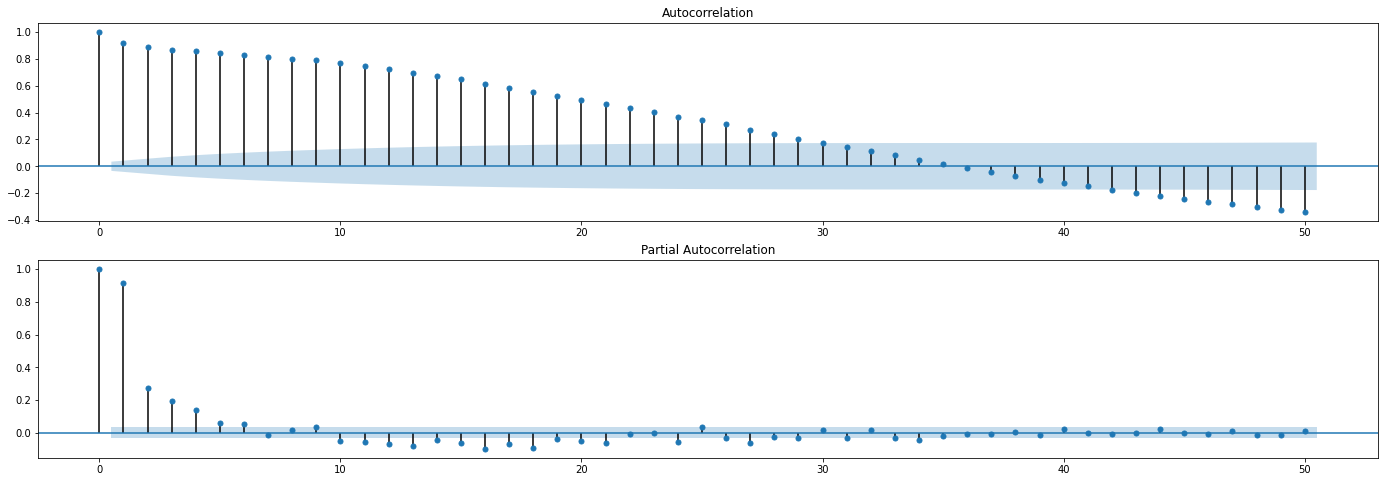

In [0]:
fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(df['Monthly Mean Total Sunspot Number'], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(df['Monthly Mean Total Sunspot Number'], lags=50, ax=ax2)
plt.show()

Графики выше показывают зависимость элементов временного ряда между собой.

### Задание 2. Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.


In [0]:
train_data = df['Monthly Mean Total Sunspot Number'][:-300]
test_data = df['Monthly Mean Total Sunspot Number'][-300:]

### Задание 3. Примените модель ARIMA для прогнозирования значений данного временного ряда.

Так как наш ряд нестационарный, а ARMA модель работает только со стационарными, необходимо воспользоваться моделью ARIMA.

Ввиду того, что первоначальный подбор параметров ARIMA не дал хороших результатов, было решено воспользоваться auto_arime функцией для оценки параметров модели.

In [0]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 3.4MB/s 


In [0]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [0]:
arima_model = auto_arima(df['Monthly Mean Total Sunspot Number'],
                            n_jobs=-1,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=False, random=True,
                           n_fits=1000)

In [0]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3252
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -15034.244
Date:                Sun, 19 Apr 2020   AIC                          30082.487
Time:                        10:25:01   BIC                          30125.096
Sample:                             0   HQIC                         30097.751
                               - 3252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1096      0.029      3.790      0.000       0.053       0.166
ar.L1          2.2976      0.020    112.458      0.000       2.258       2.338
ar.L2         -1.6337      0.040    -40.432      0.000      -1.713      -1.555
ar.L3          0.3349      0.021     16.215      0.000       0.294       0.375
ma.L1         -1.7645      0.014   -123.727      0.000      -1.792      -1.737
ma.L2          0.7930      0.014     57.021      0.000       0.766       0.820
sigma2       602.2990      9.689     62.166      0.000     583.310     621.288
===================================================================================
Ljung-Box (Q):                       82.75   Jarque-Bera (JB):              1481.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.48
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Вычислим предсказания, используя модель ARIMA и проанализированные параметры выше.

In [0]:
history = train_data.values.tolist()

arima_predictions = list()
for t in range(len(test_data)):
	model = ARIMA(history, order=(3,0,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	arima_predictions.append(yhat)
	obs = test_data[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=32.558608, expected=32.600000
predicted=32.245952, expected=45.800000
predicted=39.026939, expected=46.300000
predicted=40.358227, expected=21.600000
predicted=28.551831, expected=19.400000
predicted=26.003328, expected=22.500000
predicted=26.374466, expected=20.400000
predicted=24.701669, expected=18.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=22.655506, expected=15.700000
predicted=20.673996, expected=30.600000
predicted=27.627764, expected=14.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=19.658879, expected=14.900000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=19.299920, expected=13.300000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.918760, expected=7.700000
predicted=14.519593, expected=12.600000
predicted=16.060278, expected=6.800000
predicted=12.727387, expected=7.600000
predicted=12.435548, expected=16.500000
predicted=16.776041, expected=11.800000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.700025, expected=19.700000
predicted=18.927591, expected=3.000000
predicted=10.999523, expected=0.700000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.004620, expected=24.900000
predicted=20.932184, expected=14.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.801240, expected=7.400000
predicted=13.740330, expected=11.000000
predicted=15.520752, expected=12.100000
predicted=16.157262, expected=23.000000
predicted=22.305388, expected=25.400000
predicted=24.772990, expected=20.800000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=23.738033, expected=12.900000
predicted=20.338396, expected=35.700000
predicted=32.381148, expected=59.700000
predicted=47.042066, expected=32.800000
predicted=36.945993, expected=50.400000
predicted=47.188646, expected=55.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=52.336433, expected=44.500000
predicted=49.082141, expected=50.200000
predicted=53.170304, expected=82.000000
predicted=71.432983, expected=70.600000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=69.577726, expected=74.000000
predicted=73.659001, expected=90.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=84.646046, expected=96.700000
predicted=91.324537, expected=121.100000
predicted=107.721882, expected=132.000000
predicted=118.602339, expected=78.500000
predicted=95.632376, expected=97.300000
predicted=104.682483, expected=119.200000
predicted=117.143096, expected=86.000000
predicted=102.375712, expected=98.000000
predicted=107.483615, expected=103.500000
predicted=110.453128, expected=93.600000
predicted=105.433473, expected=149.600000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=134.088926, expected=207.200000
predicted=169.069691, expected=173.500000
predicted=160.491917, expected=142.300000
predicted=148.466451, expected=106.300000
predicted=130.163716, expected=168.700000
predicted=160.111834, expected=188.300000
predicted=173.523215, expected=116.800000
predicted=140.082880, expected=133.100000
predicted=145.374281, expected=165.700000
predicted=161.005831, expected=217.700000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=190.097291, expected=191.500000
predicted=182.311345, expected=165.900000
predicted=171.547397, expected=188.000000
predicted=182.923445, expected=244.300000
predicted=214.210307, expected=180.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=187.018455, expected=156.000000
predicted=173.471630, expected=141.600000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=162.782404, expected=158.100000
predicted=167.237198, expected=143.300000
predicted=157.089460, expected=142.600000
predicted=153.159377, expected=121.500000
predicted=138.724641, expected=165.800000
predicted=157.275966, expected=161.700000
predicted=155.026863, expected=142.100000
predicted=144.234474, expected=202.900000
predicted=174.158133, expected=123.000000
predicted=135.823745, expected=161.500000
predicted=151.885422, expected=238.200000
predicted=192.370930, expected=194.100000
predicted=176.587010, expected=176.600000
predicted=169.505217, expected=213.400000
predicted=189.275946, expected=184.600000
predicted=177.689912, expected=170.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=170.466934, expected=147.100000
predicted=157.222646, expected=186.900000
predicted=174.850573, expected=187.500000
predicted=176.086974, expected=128.800000
predicted=146.018595, expected=161.000000
predicted=158.131225, expected=175.600000
predicted=164.469852, expected=187.900000
predicted=171.317993, expected=151.200000
predicted=153.486459, expected=147.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=149.153911, expected=135.300000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=140.601958, expected=133.500000
predicted=136.572190, expected=75.700000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=103.275780, expected=100.700000
predicted=108.483625, expected=97.900000
predicted=102.586387, expected=86.800000
predicted=92.809607, expected=118.700000
predicted=105.411849, expected=128.300000
predicted=109.909116, expected=115.400000
predicted=103.832930, expected=78.500000
predicted=83.970649, expected=97.800000
predicted=90.418947, expected=82.900000
predicted=81.361125, expected=72.200000
predicted=73.452659, expected=60.600000
predicted=64.536377, expected=74.600000
predicted=68.558976, expected=74.800000
predicted=67.293151, expected=59.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=58.137231, expected=72.800000
predicted=63.192109, expected=66.500000
predicted=59.589115, expected=83.800000
predicted=68.026570, expected=69.700000
predicted=61.875612, expected=48.800000
predicted=50.826102, expected=74.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=62.307132, expected=70.100000
predicted=61.114253, expected=28.900000
predicted=40.032032, expected=48.100000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=46.930614, expected=43.500000
predicted=43.529799, expected=39.600000
predicted=40.430269, expected=38.700000
predicted=38.894010, expected=61.900000
predicted=50.053557, expected=56.800000
predicted=49.019936, expected=62.400000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=52.850454, expected=60.500000
predicted=53.366171, expected=37.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=42.315435, expected=13.200000
predicted=28.707369, expected=27.500000
predicted=32.944214, expected=59.300000
predicted=48.369872, expected=20.900000
predicted=30.149892, expected=5.700000
predicted=20.291621, expected=17.300000
predicted=23.402080, expected=50.300000
predicted=39.362849, expected=37.200000
predicted=34.527716, expected=24.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=28.579741, expected=22.200000
predicted=26.674409, expected=20.800000
predicted=25.279184, expected=23.700000
predicted=26.170480, expected=14.900000
predicted=21.336461, expected=35.700000
predicted=31.326470, expected=22.300000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=25.513579, expected=29.300000
predicted=29.055478, expected=18.400000
predicted=23.932507, expected=7.200000
predicted=17.581325, expected=5.400000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.204246, expected=19.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=21.245209, expected=21.300000
predicted=22.521332, expected=15.100000
predicted=19.578051, expected=9.800000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.618127, expected=4.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.070674, expected=1.500000
predicted=10.605367, expected=2.800000
predicted=10.310851, expected=17.300000
predicted=17.053365, expected=4.100000
predicted=11.005135, expected=2.900000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.851528, expected=15.500000
predicted=15.828121, expected=3.600000
predicted=10.496751, expected=4.600000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.629495, expected=5.200000
predicted=10.623006, expected=0.600000
predicted=8.109567, expected=0.300000
predicted=7.597078, expected=1.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.569152, expected=4.200000
predicted=8.920799, expected=6.600000
predicted=10.441228, expected=1.000000
predicted=7.753240, expected=1.300000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.749936, expected=1.200000
predicted=7.597868, expected=0.600000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.228072, expected=1.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.462358, expected=2.900000
predicted=8.489855, expected=6.300000
predicted=10.329046, expected=5.500000
predicted=10.445424, expected=0.000000
predicted=8.054560, expected=7.100000
predicted=11.504281, expected=7.700000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.468273, expected=6.900000
predicted=12.458931, expected=16.300000
predicted=17.798400, expected=19.500000
predicted=20.718244, expected=28.500000
predicted=26.813529, expected=24.000000
predicted=26.502968, expected=10.400000
predicted=20.654981, expected=13.900000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=22.296927, expected=18.800000
predicted=25.086129, expected=25.200000
predicted=28.978809, expected=29.600000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=32.210776, expected=36.400000
predicted=37.044859, expected=33.600000
predicted=37.273865, expected=34.400000
predicted=38.835412, expected=24.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=34.651304, expected=27.300000
predicted=36.084941, expected=48.300000
predicted=47.094556, expected=78.600000
predicted=65.037675, expected=76.100000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=68.305233, expected=58.200000
predicted=62.503970, expected=56.100000
predicted=62.736716, expected=64.500000
predicted=68.099208, expected=65.800000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=70.073773, expected=120.100000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=99.861620, expected=125.700000
predicted=109.019770, expected=139.100000
predicted=121.708898, expected=109.300000
predicted=112.096874, expected=94.400000
predicted=106.290744, expected=47.800000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=81.856178, expected=86.600000
predicted=97.869768, expected=85.900000
predicted=97.172497, expected=96.500000
predicted=102.048491, expected=92.000000
predicted=99.978945, expected=100.100000
predicted=103.952256, expected=94.800000
predicted=101.513357, expected=93.700000
predicted=100.616333, expected=76.500000
predicted=91.033415, expected=87.600000
predicted=94.726696, expected=56.800000
predicted=77.509000, expected=96.100000
predicted=94.578458, expected=60.900000
predicted=76.284846, expected=78.300000
predicted=82.376811, expected=107.300000
predicted=96.834622, expected=120.200000
predicted=105.421888, expected=76.700000
predicted=85.362069, expected=86.200000
predicted=88.827635, expected=91.800000
predicted=91.110997, expected=54.500000
predicted=71.438089, expected=114.400000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=99.515092, expected=113.900000
predicted=102.030410, expected=124.200000
predicted=109.606807, expected=117.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=108.927591, expected=146.100000
predicted=126.113781, expected=128.700000
predicted=121.204699, expected=112.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=114.765505, expected=112.500000
predicted=114.776678, expected=102.900000
predicted=109.727338, expected=100.200000
predicted=107.295466, expected=106.900000
predicted=109.616167, expected=130.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=121.317555, expected=90.000000
predicted=101.970614, expected=103.600000
predicted=106.773162, expected=112.900000
predicted=110.866058, expected=93.000000
predicted=100.530632, expected=66.700000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=84.966362, expected=54.500000
predicted=74.428017, expected=75.300000
predicted=80.589357, expected=88.800000
predicted=85.652423, expected=66.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=73.449168, expected=65.800000
predicted=70.742278, expected=64.400000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=67.794204, expected=78.600000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=73.433688, expected=63.600000
predicted=65.348205, expected=62.200000
predicted=63.160264, expected=58.000000
predicted=59.642146, expected=57.000000
predicted=57.697130, expected=56.400000
predicted=56.264376, expected=54.100000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=54.070806, expected=37.900000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=44.447824, expected=51.500000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=49.362926, expected=20.500000
predicted=32.459360, expected=32.400000
predicted=35.430238, expected=50.200000
predicted=43.314068, expected=44.600000
predicted=40.821169, expected=33.400000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=34.812214, expected=21.400000
predicted=27.534722, expected=18.500000
predicted=24.172264, expected=26.100000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=26.437903, expected=26.400000
predicted=25.935628, expected=17.700000
predicted=20.936443, expected=32.300000
predicted=27.586948, expected=18.900000
predicted=21.122675, expected=19.200000
predicted=20.650293, expected=17.800000
predicted=19.505717, expected=32.600000
predicted=27.032265, expected=43.700000
predicted=33.979601, expected=13.200000
predicted=20.080644, expected=5.700000
predicted=15.180153, expected=8.200000
predicted=15.027886, expected=6.800000
predicted=13.419752, expected=10.700000
predicted=14.474333, expected=2.500000
predicted=9.805637, expected=8.900000
predicted=12.175388, expected=13.100000
predicted=14.213085, expected=15.600000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.847046, expected=1.600000
predicted=9.049356, expected=8.700000
predicted=12.031056, expected=3.300000
predicted=9.250979, expected=4.900000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.697654, expected=4.900000
predicted=9.558632, expected=3.100000
predicted=8.542390, expected=7.700000
predicted=10.788953, expected=0.800000
predicted=7.476954, expected=9.400000
predicted=11.788956, expected=9.100000
predicted=12.106106, expected=9.900000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.032391, expected=1.200000


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.989003, expected=0.900000
predicted=8.485416, expected=0.500000
predicted=7.981104, expected=1.100000
predicted=8.120503, expected=0.400000
predicted=7.483654, expected=0.500000
predicted=7.346065, expected=1.600000


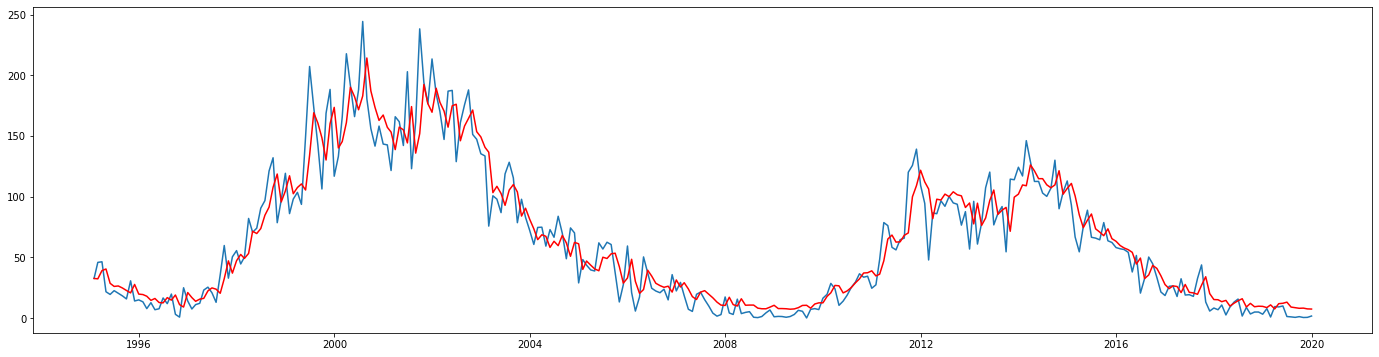

In [0]:
plt.figure(figsize=(24,6))
plt.plot(test_data.keys(), test_data.values)
plt.plot(test_data.keys(), arima_predictions, 'r')

Предсказания получились довольно неплохими.

### Задание 4. Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).


Для получения лучших результатов нормализуем начальные данные.

In [0]:
df.keys()

Index(['index', 'Unnamed: 0', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [0]:
from sklearn.preprocessing import MinMaxScaler  

In [0]:
scaler = MinMaxScaler()
scaler.fit(df[['index', 'Monthly Mean Total Sunspot Number']])
scaled_dataset = scaler.transform(df[['index', 'Monthly Mean Total Sunspot Number']])

In [0]:
scaled_dataset

array([[0.00000000e+00, 2.42842793e-01],
       [3.07597662e-04, 2.61928679e-01],
       [6.15195325e-04, 2.93068810e-01],
       ...,
       [9.99384805e-01, 1.00452034e-03],
       [9.99692402e-01, 1.25565043e-03],
       [1.00000000e+00, 4.01808137e-03]])

In [0]:
WINDOW_LENGTH = 36

def build_dataset(sequence, steps):
    dataset, labels = [], []
    for i in range(len(sequence)):
        end = i + steps
        if end > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end], sequence[end]
        dataset.append(seq_x)
        labels.append(seq_y)
    return np.array(dataset).astype('float32'), np.array(labels).astype('float32')

In [0]:
dataset, labels = build_dataset(scaled_dataset[:, 1], WINDOW_LENGTH)
print(dataset.shape)
print(labels.shape)
train_x, validation_x, train_y, validation_y = dataset[:-300], dataset[-300:], labels[:-300], labels[-300:]

(3216, 36)
(3216,)


In [0]:
train_x = np.reshape(train_x, (*train_x.shape, 1))
validation_x = np.reshape(validation_x, (*validation_x.shape, 1))

In [0]:
train_x.shape

(2814, 36, 1)

Построим модель с 2-мя LSTM слоями.

In [0]:
layers = [
    tf.keras.layers.LSTM(200, activation='relu', input_shape=(WINDOW_LENGTH, 1), return_sequences=True),
    tf.keras.layers.LSTM(200, activation='relu'),
    tf.keras.layers.Dense(1)
]

In [0]:
model = tf.keras.models.Sequential(layers=layers)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 36, 200)           161600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(train_x, train_y, epochs=20)

Epoch 1/20
92/92 [==============================] - 10s 108ms/step - loss: 0.0654
Epoch 2/20
92/92 [==============================] - 10s 106ms/step - loss: 0.0510
Epoch 3/20
92/92 [==============================] - 10s 107ms/step - loss: 0.0514
Epoch 4/20
92/92 [==============================] - 10s 107ms/step - loss: 0.0518
Epoch 5/20
92/92 [==============================] - 10s 106ms/step - loss: 0.0498
Epoch 6/20
92/92 [==============================] - 10s 107ms/step - loss: 0.0489
Epoch 7/20
92/92 [==============================] - 10s 108ms/step - loss: 0.0480
Epoch 8/20
92/92 [==============================] - 10s 111ms/step - loss: 0.0487
Epoch 9/20
92/92 [==============================] - 10s 108ms/step - loss: 0.0467
Epoch 10/20
92/92 [==============================] - 10s 108ms/step - loss: 0.0455
Epoch 11/20
92/92 [==============================] - 10s 109ms/step - loss: 0.0461
Epoch 12/20
92/92 [==============================] - 10s 107ms/step - loss: 0.0452
Epoch 13/20
9

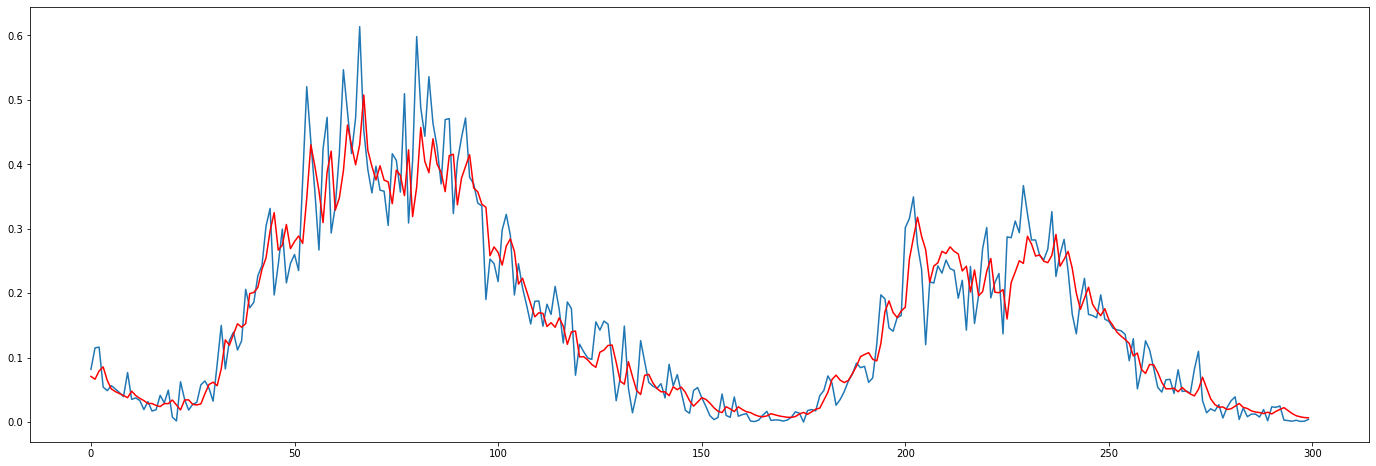

In [0]:
predictions = model.predict(validation_x)
plt.figure(figsize=(24,8))
plt.plot(validation_y)
plt.plot(predictions, color='red')
plt.show()

Преобразуем нормированные предсказания в реальные.

In [0]:
scaled_dataset_predictions = np.stack((scaled_dataset[-len(predictions):, 0], predictions[:, 0]), axis=1)

In [0]:
lstm_predictions = scaler.inverse_transform(scaled_dataset_predictions)[:, 1]

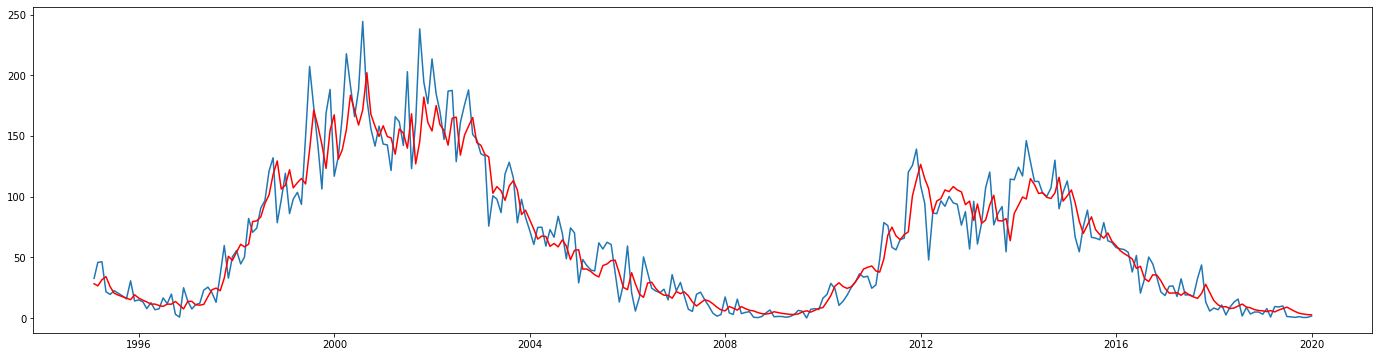

In [0]:
plt.figure(figsize=(24,6))
plt.plot(test_data.keys(), test_data.values)
plt.plot(test_data.keys(), lstm_predictions, 'r')

Данная модель показывает хорошие результаты.

### Задание 5. Сравните качество прогноза моделей.


In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
lstm_mse_error = mean_squared_error(test_data.values, lstm_predictions)
mean_value = df['Monthly Mean Total Sunspot Number'].mean()

print(f'MSE Error: {lstm_mse_error}\nMean: {mean_value}')

MSE Error: 371.9272445714576
Mean: 82.07069495694965


In [0]:
arima_mse_error = mean_squared_error(test_data.values, arima_predictions)
mean_value = df['Monthly Mean Total Sunspot Number'].mean()

print(f'MSE Error: {arima_mse_error}\nMean: {mean_value}')

MSE Error: 359.2425636443434
Mean: 82.07069495694965


Приведенные выше вычисления показывают, что ARIMA модель показывает немногим лучшие результаты, чем наша LSTM модель.